### Notebook Overview

This notebook demonstrates how to:
1. Access and download Sentinel-2 satellite imagery for a specific area and date range using the STAC API.
2. Apply cloud masks to remove cloudy areas from the images.
3. Generate true-color (RGB) images and calculate common **spectral indices** (e.g., NDVI, MSAVI) to analyze vegetation health and other land features.
4. Save the results as **Cloud Optimized GeoTIFFs (COGs)** for further use in GIS applications.


### What is STAC and How Are We Using It?

**STAC (SpatioTemporal Asset Catalog)** is a standardized way to organize and search large collections of satellite and other Earth observation data. Instead of downloading huge amounts of data, we can use STAC endpoints (web services) to search for specific satellite images based on criteria like location, time, or type of imagery.

In this notebook, we're using a **STAC endpoint** to search for and download **Sentinel-2 satellite images** of our target area. This allows us to:
- Define the **region of interest** using a geographic boundary (bounding box).
- Specify the **date range** for when we want the images (e.g., May 20 to May 28, 2024).
- Choose which **bands** (types of light) we want from the satellite imagery, such as visible light, infrared, or the cloud mask.

We are using functions like `initialize_stac_client()`, `query_most_recent_image()`, and `stac_to_array_odc()` to:
1. Connect to the STAC service.
2. Search for the most recent images in the target area.
3. Load those images into the notebook for analysis.


### What Are Spectral Indices and How Are We Calculating Them?

**Spectral indices** are mathematical combinations of different bands captured by satellites. These indices are used to highlight specific features of the Earth's surface, such as vegetation health, water content, or soil moisture. 

For example:
- **NDVI (Normalized Difference Vegetation Index)** is often used to measure vegetation health by comparing near-infrared (NIR) and red light.
- **MSAVI (Modified Soil-Adjusted Vegetation Index)** helps reduce soil noise when analyzing vegetation.
- **NDREI (Normalized Difference Red Edge Index)** can be useful for detecting stress in plants.

#### How Are We Calculating Spectral Indices?

In this notebook, we calculate these indices using Sentinel-2's bands:
1. **Choosing the bands**: Each index is computed using a specific combination of bands. For example, NDVI uses the near-infrared (NIR) and red bands.
2. **Function**: The function `compute_spectral_indices()` performs the calculation by combining the appropriate bands for each index. It uses a mapping dictionary (`band_map`) that specifies which bands to use for each index.
3. The indices are stored in arrays (data structures) that we can use for further analysis or visualization.


In [1]:
%pip install spyndex -q
%pip install jupyter_bokeh -q
%pip install odc-stac -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
from io import StringIO
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd

import rioxarray

from dask.distributed import Client as d_client

import matplotlib.pyplot as plt
import pystac_client

import spyndex
from odc.stac import configure_s3_access, load


os.environ['AWS_ACCESS_KEY_ID'] = 'your_access_key'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'your_secret_key'


/usr/local/lib/python3.10/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Dask Client Setup and S3 Access Configuration

- **Dask Client**: The `dask_client()` function is initialized and displayed to set up a Dask distributed client for parallel and distributed computing.
  
- **S3 Access Configuration**: The `configure_s3_access()` function configures access to S3 for retrieving Sentinel-2 imagery. The parameters used include:

### Parallel Computing with Dask

The notebook uses **Dask**, a library for parallel computing, to speed up the processing of large satellite images. 
- When dealing with large datasets, Dask helps by splitting the work across multiple cores or machines. 
- This is useful when downloading, processing, and analyzing satellite images, which can involve large amounts of data.


In [3]:
dask_client = d_client()
dask_client

configure_s3_access(
    cloud_defaults = True,
    aws_unsigned = True
)

### Functions for STAC Data Retrieval, Cloud Masking, True Color Image Creation, and Spectral Index Computation

1. **initialize_stac_client()**:
    - Initializes a STAC client using a given STAC API URL.

2. **query_stac_api()**:
    - Queries a STAC API for satellite data within a bounding box and date range, returning a collection of STAC items.

3. **query_most_recent_image()**:
    - Queries the STAC API for the most recent image within the provided bounding box and date range.

4. **stac_to_array_odc()**:
    - Converts the queried STAC items into an `xarray.DataArray` using the `odc-stac` package. 
    - Allows you to specify the bands and bounding box for the resulting datacube.

5. **apply_scl_mask()**:
    - Applies a cloud mask using the Scene Classification Layer (SCL). The mask removes cloudy pixels based on predefined SCL values.

6. **create_true_color_image()**:
    - Generates a true-color image (RGB) using the red, green, and blue bands from the provided dataset.

7. **compute_spectral_indices()**:
    - Computes spectral indices (e.g., NDVI, MSAVI) using the specified bands in the dataset. 

8. **plot_index()**:
    - Plots spectral indices (e.g., NDVI) from the dataset over time, using a colormap.

9. **plot_rgb_image()**:
    - Plots a true-color (RGB) image, applying a percentile stretch to enhance contrast.

10. **save_index_as_cog()**:
    - Saves a spectral index (e.g., NDVI, MSAVI) as a Cloud Optimized GeoTIFF (COG), preserving spatial metadata such as CRS (Coordinate Reference System).

11. **save_rgb_as_cog()**:
    - Saves the true-color (RGB) image as a Cloud Optimized GeoTIFF (COG), retaining spatial information.
    - Removes singleton dimensions (such as `time`) and ensures proper handling of spatial metadata and CRS.


In [4]:
def initialize_stac_client(stac_url):
    """
    Initialize and return a STAC client for a given STAC API URL.
    """
    return pystac_client.Client.open(stac_url)


def query_stac_api(client, collections, bbox, start_date=None, end_date=None, max_items=10):
    """
    Query a STAC API for items within a bounding box and date range for specific collections.
    Parameters:
    - client: The STAC client initialized with `initialize_stac_client`.
    - bbox (list): The bounding box for the query [min_lon, min_lat, max_lon, max_lat].
    - collections (list): A list of collection IDs to include in the query.
    - start_date (str, optional): The start date for the query (YYYY-MM-DD). Defaults to None.
    - end_date (str, optional): The end date for the query (YYYY-MM-DD). Defaults to None.
    - limit (int): Maximum number of items to return.    
    Returns:
    - A list of STAC Items that match the query parameters.
    """

    search_params = {
        "bbox": bbox,
        "collections": [collections],
        "max_items": max_items
    }
    if start_date and end_date:
        search_params["datetime"] = f"{start_date}/{end_date}"

    search = client.search(**search_params).item_collection()
    return search

def query_most_recent_image(client, collections, bbox, start_date=None, end_date=None):
    """
    Query the STAC API for the most recent image within the date range and bounding box.
    """
    search_params = {
        "bbox": bbox,
        "collections": [collections],
        "max_items": 1,  # Only retrieve the most recent image
        "sortby": [{"field": "properties.datetime", "direction": "desc"}]  # Sort by date descending
    }
    
    if start_date and end_date:
        search_params["datetime"] = f"{start_date}/{end_date}"
    else:
        end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
        start_date = (pd.Timestamp.now() - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
        search_params["datetime"] = f"{start_date}/{end_date}"
    
    search = client.search(**search_params).item_collection()
    return search

def stac_to_array_odc(stac_items, bbox, requested_bands):
    """
    Converts STAC item collection to a data array using odc-stac that includes the requested bands.
    
    Parameters:
    - stac_items (list): A list of STAC items.
    - requested_bands (list): A list of bands to include in the datacube.
    - bbox (list): Bounding box [min_lon, min_lat, max_lon, max_lat].
    
    Returns:
    - stacked_data: xarray.DataArray with the requested bands and bounding box.
    """
    # Use odc-stac to load the data
    stack = load(
        stac_items,
        bands=requested_bands,
        bbox=bbox,
        crs="EPSG:3857", 
        resolution=10,
        chunks = {},
        groupby="solar_day"
    )
    
    return stack
    

    
def apply_scl_mask(data_array, scl_band='scl'):
    """
    Apply the SCL cloud mask to each time slice of the data array, preserving metadata.
    """
    if scl_band not in data_array.data_vars:
        raise KeyError(f"{scl_band} layer (scene classification) is not found in the dataset.")
    
    scl_cloud_values = [3, 8, 9, 10, 11]  # SCL values indicating cloud and cloud shadow
    scl = data_array[scl_band]  # Extract the SCL layer

    # Create mask where SCL values are clouds
    scl_mask = scl.isin(scl_cloud_values)
    
    # Apply mask across the entire data array (except the SCL band)
    masked_data_array = data_array.where(~scl_mask, other=np.nan)
    
    return masked_data_array

def create_true_color_image(data_array):
    """
    Create a true color image (RGB) from an xarray.Dataset containing 'red', 'green', and 'blue' bands.

    Parameters:
    - data_array: xarray.Dataset containing spectral bands as data variables (including 'red', 'green', and 'blue').

    Returns:
    - rgb_array: xarray.Dataset containing only the 'red', 'green', and 'blue' bands.
    """
    # Ensure that the necessary bands are present in the dataset
    if not all(band in data_array.data_vars for band in ['red', 'green', 'blue']):
        raise KeyError("Dataset must contain 'red', 'green', and 'blue' bands.")
    
    # Select the red, green, and blue bands to create a true color image
    rgb_array = data_array[["red", "green", "blue"]]
    
    return rgb_array

def compute_spectral_indices(data_array, indices_to_compute, band_map):
    """
    Compute spectral indices using the bands stored as data variables in an xarray.Dataset.
    
    Parameters:
    - data_array: xarray.Dataset containing spectral bands as data variables.
    - indices_to_compute: List of spectral indices to compute (e.g., ['NDVI', 'MSAVI']).
    - band_map: Dictionary mapping indices to the required bands.

    Returns:
    - computed_indices: A dictionary containing the computed indices as xarray.DataArray objects.
    """
    computed_indices = {}
    
    # Loop through the indices and compute each one
    for index in indices_to_compute:
        if index in band_map:
            # Access the relevant bands from the dataset
            bands = {key: data_array[value] for key, value in band_map[index].items()}
            
            # Compute the index using spyndex
            result = spyndex.computeIndex(index=index, params=bands).clip(-1, 1).compute()
            
            # Replace NaNs with 0 for valid output
            computed_indices[index] = result.where(np.isfinite(result), 0)
    
    return computed_indices

def plot_index(index_array):
    """
    Plot the NDVI result.
    
    Parameters:
    - ndvi_array: xarray.DataArray containing the computed NDVI.
    """
    # Plot the NDVI for each time slice (if applicable)
    for t in range(index_array.sizes['time']):
        plt.figure(figsize=(6, 6))
        plt.imshow(index_array.isel(time=t), cmap='RdYlGn', vmin=-1, vmax=1)
        plt.title(f"NDVI - Time Slice {t+1}")
        plt.colorbar(label="NDVI")
        plt.axis('off')
        plt.show()

def plot_rgb_image(rgb_array, percentile_stretch=(1, 99)):
    """
    Plot a true color RGB image from an xarray.Dataset with 'red', 'green', and 'blue' bands,
    applying a percentile stretch for contrast enhancement.
    
    Parameters:
    - rgb_array: xarray.Dataset or DataArray containing the 'red', 'green', and 'blue' bands.
    - percentile_stretch: Tuple of percentiles to apply for contrast stretching (default: (1, 99)).
    """
    # Extract red, green, and blue bands from the dataset
    red = rgb_array['red']
    green = rgb_array['green']
    blue = rgb_array['blue']

    # Compute the percentile stretch for each band
    red_vmin, red_vmax = np.nanpercentile(red, percentile_stretch)
    green_vmin, green_vmax = np.nanpercentile(green, percentile_stretch)
    blue_vmin, blue_vmax = np.nanpercentile(blue, percentile_stretch)

    # Apply the percentile stretch and normalize the RGB bands to [0, 1]
    red_stretch = np.clip((red - red_vmin) / (red_vmax - red_vmin), 0, 1)
    green_stretch = np.clip((green - green_vmin) / (green_vmax - green_vmin), 0, 1)
    blue_stretch = np.clip((blue - blue_vmin) / (blue_vmax - blue_vmin), 0, 1)

    # Stack the stretched bands along the last axis to form an RGB image
    rgb_stack = np.stack([red_stretch, green_stretch, blue_stretch], axis=-1)
    
    # Plot the RGB image for each time slice (if applicable)
    for t in range(rgb_stack.shape[0]):
        plt.figure(figsize=(6, 6))
        plt.imshow(rgb_stack[t, :, :, :], vmin=0, vmax=1)  # RGB values are now in [0, 1] range
        plt.title(f"RGB Image - Time Slice {t+1}")
        plt.axis('off')
        plt.show()




def save_index_as_cog(index_array, output_path, file_name):
    """
    Save the spectral index (NDVI, MSAVI, etc.) as a Cloud Optimized GeoTIFF (COG), retaining spatial information.
    
    Parameters:
    - index_array: xarray.DataArray containing the computed spectral index.
    - output_path: The directory where the GeoTIFF will be saved.
    - file_name: The name of the output file.
    """
    output_file = os.path.join(output_path, file_name)
    
    # Ensure that the DataArray has a CRS defined before saving
    if not index_array.rio.crs:
        raise ValueError("The dataset does not have a CRS. Assign a CRS before saving.")
    
    # Write to COG using rioxarray with cloud-optimized options
    index_array.rio.to_raster(
        output_file, 
        tiled=True,  # Enable tiling for Cloud Optimized GeoTIFFs
        windowed=True,  # Enable windowed reading
        compress="deflate",  # Compression to reduce file size
        driver="COG"
    )
    
    print(f"Saved index image as {output_file}")


def save_rgb_as_cog(rgb_array, output_path, file_name="rgb_image.tif"):
    """
    Save the true color RGB image as a Cloud Optimized GeoTIFF (COG), retaining spatial information.
    
    Parameters:
    - rgb_array: xarray.Dataset containing the 'red', 'green', and 'blue' bands.
    - output_path: The directory where the GeoTIFF will be saved.
    - file_name: The name of the output file (default: 'rgb_image.tif').
    """
    # Squeeze to remove any singleton dimensions like 'time'
    rgb_array = rgb_array.squeeze()

    # Stack the red, green, and blue bands into a 3D array (bands, y, x)
    rgb_stack = np.stack([rgb_array['red'].values, rgb_array['green'].values, rgb_array['blue'].values], axis=0)
    
    # Convert to xarray.DataArray with a 'band' dimension
    rgb_xarray = xr.DataArray(
        rgb_stack, 
        dims=['band', 'y', 'x'],  # Set the correct dimensions
        coords={
            'band': ['red', 'green', 'blue'],  # Name the bands
            'y': rgb_array.coords['y'],
            'x': rgb_array.coords['x']
        },
        attrs=rgb_array.attrs  # Retain original attributes like CRS
    )
    
    # Extract CRS from the 'spatial_ref' coordinate
    if 'spatial_ref' in rgb_array.coords:
        crs = rgb_array['spatial_ref'].attrs.get('crs_wkt', None)  # Check for 'crs_wkt' or similar attributes
        if crs:
            rgb_xarray.rio.write_crs(crs, inplace=True)
        else:
            raise ValueError("CRS information not found in 'spatial_ref' coordinate.")
    else:
        raise ValueError("The dataset does not have a 'spatial_ref' coordinate.")
    
    # Write to Cloud Optimized GeoTIFF (COG)
    output_file = os.path.join(output_path, file_name)
    rgb_xarray.rio.to_raster(
        output_file, 
        tiled=True,  # Enable tiling for COG
        windowed=True,  # Allow windowed reading
        compress="deflate",  # Compression to reduce file size
        driver="COG"
    )
    
    print(f"Saved RGB image as {output_file}")


### Reading and Transforming the Shapefile

- **Read the Shapefile**: 
    - The `gpd.read_file()` function reads the shapefile `EXTRACT_POLYGON.shp`, which defines the region of interest (ROI) for satellite imagery analysis.
    
- **Reproject to EPSG:4326**:
    - The shapefile is reprojected to the WGS 84 coordinate system (`EPSG:4326`), ensuring compatibility with geographic datasets that use latitude and longitude coordinates.
    
- **Bounding Box Calculation**:
    - The bounding box (`bbox`) is extracted from the shapefile, representing the geographic extent of the region of interest in the format `[min_lon, min_lat, max_lon, max_lat]`. This bounding box will be used to query satellite data from the STAC API.


### Loading the Target Area for Analysis

We start by defining the **region of interest (ROI)** using a shapefile. The shapefile contains geographic boundaries that tell us exactly where on Earth we want to focus our analysis. 
1. The shapefile is reprojected to a common coordinate system (EPSG:4326), which uses latitude and longitude. This is important for compatibility with satellite data.
2. From this, we extract a **bounding box** (the geographic limits of the area) to use when querying satellite images.


In [5]:
geom = gpd.read_file('/workspace/notebooks/sandbox/data/hallsgap/EXTRACT_POLYGON.shp')
geom = geom.to_crs(epsg=4326)
bbox = list(geom.total_bounds)

In [6]:
# geojson = {
#     'body': {
#         "type": "FeatureCollection",
#         "name": "tooradin-index-test",
#         "crs": {
#             "type": "name",
#             "properties": {
#                 "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
#             }
#         },
#         "features": [
#             {
#                 "type": "Feature",
#                 "properties": {
#                     "fid": 1
#                 },
#                 "geometry": {
#                     "type": "Polygon",
#                     "coordinates": [
#                         [
#                             [
#                             145.4258403846071,
#                             -38.16157402964695
#                             ],
#                             [
#                             145.42009713692318,
#                             -38.19027315710604
#                             ],
#                             [
#                             145.43697070957484,
#                             -38.192337658438625
#                             ],
#                             [
#                             145.4434262980555,
#                             -38.16360433936431
#                             ],
#                             [
#                             145.4258403846071,
#                             -38.16157402964695
#                             ]
#                         ]
#                     ]
#                 }
#             }
#         ]
#     }
# }

In [7]:
# req = geojson
# geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

# # Convert the GeoJSON string to a GeoDataFrame
# geom = gpd.read_file(StringIO(json.dumps(geojson_data)))

### Setting Up Paths and Querying Sentinel-2 Data

- **STAC API for Sentinel-2**:
    - `stac_url_sentinel` is the web address for accessing public satellite data (Sentinel-2 imagery) through the STAC API.

- **Collection and Date Range**:
    - The notebook will work with Sentinel-2 Level 2A satellite images, which provide detailed Earth observations.
    - The `start_date` and `end_date` specify the time range for the satellite images we want to download. If not provided, the notebook will default to the last 30 days.
    - Only the most recent single image will be returned.

- **Sentinel-2 Bands**:
    - `sentinel_bands` is a list of different types of light captured by the satellite. These include:


### Understanding Sentinel-2 Bands

The **Sentinel-2 satellite** captures different types of light, each stored in separate "bands." These bands are crucial for different types of analysis:
- **Red, Green, Blue (RGB)**: Visible light that helps create true-color images.
- **Near-Infrared (NIR)**: Useful for analyzing vegetation health.
- **Red-edge**: Helps detect plant stress and early signs of vegetation change.
- **Shortwave Infrared (SWIR)**: Useful for studying soil moisture and water content.
- **Scene Classification Layer (SCL)**: A special band that classifies pixels in the image as clouds, shadows, or other types of surfaces.

We will use these bands to generate clear images and calculate indices such as NDVI.


In [8]:
outpath = '/workspace/notebooks/sandbox/data/output-data/spectral-indices'


stac_url_sentinel = "https://earth-search.aws.element84.com/v1"
collection_sentinel = "sentinel-2-l2a"

start_date = "2024-05-20"
end_date = "2024-05-28"
sentinel_bands = ['blue','green','red','nir', 'rededge1', 'swir16', 'scl'] #scl MUST be included

In [9]:
client = initialize_stac_client(stac_url_sentinel)
stac_items = query_most_recent_image(client, collection_sentinel, bbox, start_date, end_date)

In [10]:
stack = stac_to_array_odc(stac_items, bbox, sentinel_bands)

### Applying Cloud Mask Using the Scene Classification Layer (SCL)

The **Scene Classification Layer (SCL)** is part of the Sentinel-2 imagery and identifies different types of features in the image, like clouds, shadows, and vegetation. 

We use the SCL to remove cloud and shadow pixels, so they don't interfere with the analysis. The function `apply_scl_mask()` applies a filter that masks out (removes) any cloudy or shadowed areas from the image.

- **Result**: An array with only the clear pixels (clouds and shadows removed), leaving the rest of the image intact for further analysis.


In [11]:
masked_stac = apply_scl_mask(stack)

In [12]:
rgb_image = create_true_color_image(masked_stac)

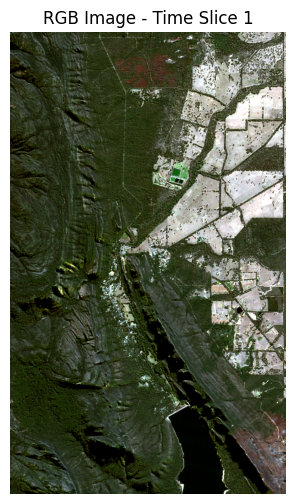

In [13]:
plot_rgb_image(rgb_image)

In [14]:
# this band_map should eventually go in some kind of configuration file.

band_map = {
    'NDVI': {'N': 'nir', 'R': 'red'},
    'MSAVI': {'N': 'nir', 'R': 'red'},
    'NDREI': {'N': 'nir', 'RE1': 'rededge1'}
}

In [15]:
indices_to_compute = ['NDVI', 'MSAVI', 'NDREI']
computed_indices = compute_spectral_indices(masked_stac, indices_to_compute, band_map)

# Access the computed NDVI
ndvi = computed_indices['NDVI']

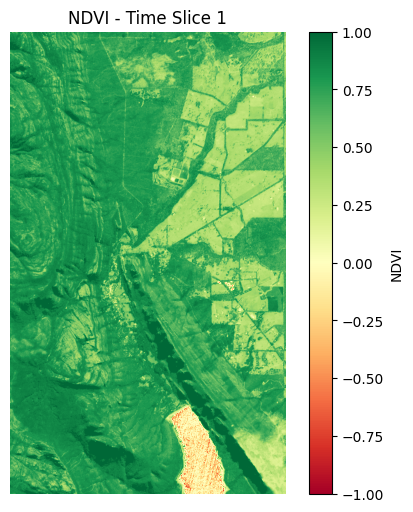

In [16]:
plot_index(ndvi)

In [17]:
rgb_image

<xarray.Dataset> Size: 49MB
Dimensions:      (time: 1, y: 1845, x: 1101)
Coordinates:
  * y            (y) float64 15kB -4.448e+06 -4.448e+06 ... -4.467e+06
  * x            (x) float64 9kB 1.586e+07 1.586e+07 ... 1.587e+07 1.587e+07
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 8B 2024-05-27T00:37:23.230000
Data variables:
    red          (time, y, x) float64 16MB dask.array<chunksize=(1, 1845, 1101), meta=np.ndarray>
    green        (time, y, x) float64 16MB dask.array<chunksize=(1, 1845, 1101), meta=np.ndarray>
    blue         (time, y, x) float64 16MB dask.array<chunksize=(1, 1845, 1101), meta=np.ndarray>

In [18]:
save_rgb_as_cog(rgb_image, outpath, file_name="true_color_rgb.tif")

Saved RGB image as /workspace/notebooks/sandbox/data/output-data/spectral-indices/true_color_rgb.tif


In [19]:
# save individual indices as COGs

for index_name, index_array in computed_indices.items():
    output_filename = f"{index_name.lower()}.tif"
    save_index_as_cog(index_array, outpath, output_filename)

Saved index image as /workspace/notebooks/sandbox/data/output-data/spectral-indices/ndvi.tif
Saved index image as /workspace/notebooks/sandbox/data/output-data/spectral-indices/msavi.tif
Saved index image as /workspace/notebooks/sandbox/data/output-data/spectral-indices/ndrei.tif
